# Mecanismo de recomendação com PySpark

<font size=3>Esse mecanismo de recomendação usa dados de feedback implícitos de um site de comércio eletrônico, que inclui interações do usuário, como visualizações, carrinhos e compras. [Link do conjunto de dados](https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store)

<font size=3>O mecanismo fornece recomendações personalizadas aos usuários usando fatoração de matriz com o algoritmo Alternating Least Squares junto com outros recursos, como compra por visualização. Além disso, identifica produtos substitutos e complementares comparando seus vetores usando o algoritmo Locality Sensitive Hashing.

<font size=3>Ao melhorar a experiência do usuário e aumentar a satisfação e retenção do cliente, o projeto visa aumentar as vendas e o lucro na plataforma. A natureza altamente personalizada das pontuações de recomendação torna este mecanismo uma ferramenta valiosa para qualquer empresa de comércio eletrônico que busca melhorar suas recomendações de produtos.

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=3a4547b71e35ed9ec848f2f1384c956f4c95ea447e47c007aaeab66592c9d5ef
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [1]:
import numpy as np
import sys
import math
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import pyarrow

import glob
import os

import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Initialize Spark session

sc = SparkSession.builder.appName("Product_Recommendation") \
.config("spark.sql.shuffle.partitions", "200") \
.config("spark.driver.maxResultSize", "2g") \
.config("spark.sql.execution.arrow.enabled", "true") \
.config("spark.driver.memory", "8g") \
.config("spark.executor.cores", "4") \
.config("spark.executor.memory", "8g") \
.config("spark.sql.execution.arrow.pyspark.enabled", "true") \
.config("spark.dynamicAllocation.enabled", "true") \
.config("spark.dynamicAllocation.minExecutors", "1") \
.config("spark.dynamicAllocation.maxExecutors", "10") \
.config("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:MaxGCPauseMillis=200") \
.config("spark.driver.extraJavaOptions", "-XX:+UseG1GC -XX:MaxGCPauseMillis=200") \
.getOrCreate()

sc.sparkContext.setLogLevel("ERROR")

24/05/27 21:56:26 WARN Utils: Your hostname, MacBook-Air-de-Henrique.local resolves to a loopback address: 127.0.0.1; using 192.168.15.19 instead (on interface en0)
24/05/27 21:56:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/27 21:56:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = sc.read.option('header', True).csv('./2019-Nov.csv')
df = df.sample(0.1, seed=321)

In [4]:
df.printSchema()
df.count()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



6751602

In [5]:
df.show(5, truncate=False)

+-----------------------+----------+----------+-------------------+--------------------------+-----+------+---------+------------------------------------+
|event_time             |event_type|product_id|category_id        |category_code             |brand|price |user_id  |user_session                        |
+-----------------------+----------+----------+-------------------+--------------------------+-----+------+---------+------------------------------------+
|2019-11-01 00:00:07 UTC|view      |27400066  |2053013563391345499|NULL                      |NULL |8.55  |551061950|3f6112f1-5695-4e88-bb0a-49f9e36658ff|
|2019-11-01 00:00:08 UTC|view      |17200558  |2053013559792632471|furniture.living_room.sofa|NULL |591.78|566280536|34e7a822-0b93-4a9a-8ce0-bae4cadb21d8|
|2019-11-01 00:00:09 UTC|view      |26019863  |2053013562837697343|NULL                      |NULL |11.79 |566280860|341a87d8-8cf4-4b4a-8b7d-749380697af1|
|2019-11-01 00:00:11 UTC|view      |1307340   |2053013558920217191|com

## Exploratory Data Analysis

In [6]:
# Null values

df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code| brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|         0|         0|         0|          0|      2189503|921267|    0|      0|           1|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+



In [7]:
# Number of events

df.groupBy('event_type').count().show()

+----------+-------+
|event_type|  count|
+----------+-------+
|  purchase|  92316|
|      view|6356866|
|      cart| 302420|
+----------+-------+



<Axes: ylabel='count'>

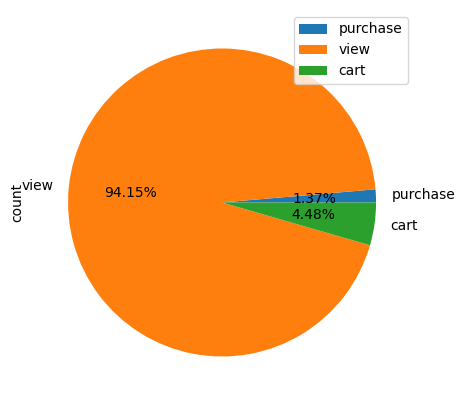

In [8]:
grouped_df = df.groupBy('event_type').agg(f.count('*').alias('count'))

# Write the DataFrame to a CSV file
output_path = './events_output'
#grouped_df.write.csv(output_path, header=True)

csv_files = glob.glob(os.path.join(output_path, '*.csv'))

if len(csv_files) == 1:
    csv_file = csv_files[0]
else:
    raise ValueError("There should be exactly one CSV file in the output directory.")

# Read the CSV file into a Pandas DataFrame
events = pd.read_csv(csv_file)
events.plot(kind='pie', y=('count'), labels=events['event_type'], autopct='%1.2f%%', figsize=(5, 5))

In [9]:
df.select(f.countDistinct("product_id")).show()

# 190k products

+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                    149293|
+--------------------------+



<font size=3>Verifique se todos os produtos pertencem a uma única categoria agrupando os produtos por seu ID, coletando seus IDs de categoria em um conjunto e imprimindo o número de produtos que pertencem a uma única categoria.

In [10]:
df.groupby('product_id').agg(f.collect_set('category_id'))\
                        .filter(size(col('collect_set(category_id)')) == 1).count()

# All products belong to a single category

149293

In [11]:
df.select(f.countDistinct("category_id")).show()

# 684 categories

+---------------------------+
|count(DISTINCT category_id)|
+---------------------------+
|                        675|
+---------------------------+



In [12]:
df.drop_duplicates(subset=['category_id']).select(f.count("category_code")).show()

+--------------------+
|count(category_code)|
+--------------------+
|                 271|
+--------------------+



In [13]:
df.select(f.countDistinct("category_code")).show()


+-----------------------------+
|count(DISTINCT category_code)|
+-----------------------------+
|                          128|
+-----------------------------+



In [14]:
df.select(f.countDistinct("user_id")).show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                1831790|
+-----------------------+



In [15]:
df.select(f.countDistinct("user_session")).show()

+----------------------------+
|count(DISTINCT user_session)|
+----------------------------+
|                     4245031|
+----------------------------+



<Axes: xlabel='date'>

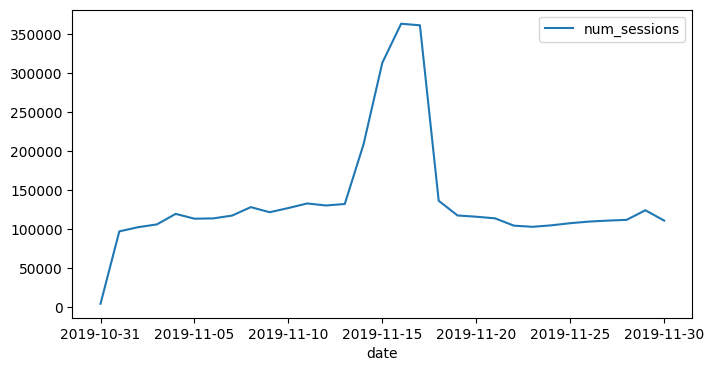

In [16]:
# Plot the daily number of sessions

df = df.withColumn('event_time', to_timestamp('event_time'))
df = df.withColumn('date', date_format("event_time", "yyyy-MM-dd"))

sessions_spark = df.groupBy('date').agg(countDistinct('user_session').alias('num_sessions'))

output_path = './sessions_output'
sessions_spark.coalesce(1).write.csv(output_path, header=True, mode='overwrite')

csv_files = glob.glob(os.path.join(output_path, '*.csv'))

if len(csv_files) == 1:
    csv_file = csv_files[0]
else:
    raise ValueError("There should be exactly one CSV file in the output directory.")

sessions = pd.read_csv(csv_file)
sessions.sort_values('date').plot(x='date', y='num_sessions', figsize=(8, 4))

<font size=3>O número de sessões aumentou sensivelmente entre 15 e 18 de novembro, o que pode ser atribuído a uma campanha publicitária ou atividade promocional.

In [17]:
# Número de interações entre usuários e produtos, classificados por carrinhos

interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1)).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1)).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1)).alias('purchases'))

In [18]:
interactions.sort('carts', ascending=False).show()

+---------+----------+-----+-----+---------+
|  user_id|product_id|views|carts|purchases|
+---------+----------+-----+-----+---------+
|512875426|  15300303|    1|   76|     NULL|
|521558076|   1005008|    1|   44|     NULL|
|571769879|  12720043| NULL|   39|     NULL|
|515642515|  13101546|    1|   22|     NULL|
|564808105|   1002633|    4|   21|     NULL|
|513824664|   3601489|    2|   21|     NULL|
|515911561|   1004858| NULL|   21|     NULL|
|564068124|   1004767|   19|   20|       19|
|553080959|  17200721|    1|   20|     NULL|
|564068124|   1004833|   27|   19|       15|
|571683521|   1004870|    2|   18|     NULL|
|536564855|   1005100| NULL|   18|     NULL|
|568461370|   3600661|    3|   18|     NULL|
|549030056|   1004856|   14|   18|        8|
|538042220|  12720092|    1|   17|     NULL|
|513754375|  50600004| NULL|   17|     NULL|
|517587461|   1005116|    1|   17|        1|
|557590749|   8800045| NULL|   16|     NULL|
|559057489|   3700912|    1|   16|     NULL|
|515212485

<font size=3>Os dados revelam um número significativo de pares usuário-produto com um grande número de carrinhos, mas muito poucas visualizações e compras.

<font size=3>Uma análise mais aprofundada mostra que muitos desses eventos de carrinho ocorreram durante a mesma sessão, o que pode ser devido aos usuários adicionarem e removerem repetidamente o produto.

<font size=3>No entanto, os dados não contêm informações sobre eventos de remoção do carrinho, portanto, devemos restringir o número de carrinhos a um por sessão para cada par usuário-produto.

## Preprocess

In [19]:
def preprocess(df):
    df = df.withColumn('event_time', to_timestamp('event_time'))
    df = df.withColumn('user_id', col('user_id').cast('integer'))
    df = df.withColumn('product_id', col('product_id').cast('integer'))
    df = df.withColumn('category_id', col('category_id').cast('long'))

    # Limita o número de carrinhos a 1 por sessão para cada par usuário-produto
    cart_df = df.filter(col('event_type') == 'cart')
    df = df.filter(col('event_type') != 'cart')
    cart_df = cart_df.dropDuplicates(subset=['product_id', 'user_id', 'user_session'])
    df = df.union(cart_df)

    # Divida os códigos de categoria em subcategorias
    df = df.withColumn('category', split(df['category_code'], '\.').getItem(0)) \
       .withColumn('sub_category', split(df['category_code'], '\.').getItem(1)) \
       .withColumn('sub_sub_category', split(df['category_code'], '\.').getItem(2))

    return df

In [20]:
df = preprocess(df)
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- date: string (nullable = true)
 |-- category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- sub_sub_category: string (nullable = true)



## Feature Engineering

<font size=3>Podemos extrair diversas características para usuários, produtos e categorias usando os dados comportamentais:


- Visualizações/carrinhos/compras: o número de vezes que um usuário interagiu com um produto.


- Produtos distintos visualizados/colocados no carrinho/comprados: o número de produtos exclusivos que um usuário visualizou, adicionou ao carrinho ou comprou.


- Preço médio (relativo) visualizado/comprado: O preço médio dos produtos que um usuário visualizou ou comprou.


- Taxas de interação: são recursos derivados que fornecem insights sobre o comportamento dos usuários, como taxa de compra por visualização, carrinho por visualização e compra por carrinho.

In [21]:
def product_features(df):

    # Calcula métricas para produtos com a função agregada
    df = df.groupby('product_id').agg(first('category_id').alias('category_id'),
                                      first('category_code').alias('category_code'),
                                      count(when(df['event_type'] == 'view', True)).alias('views'),
                                      count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                      count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                      mean('price').alias('price'),
                                      min('event_time').alias('first_date'),
                                      max('event_time').alias('last_date'))

    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', df['purchases'] / df['views'])
    df = df.withColumn('cart_per_view', df['carts'] / df['views'])
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    return df

In [22]:
def category_features(df):

    # Calcule o preço médio do produto para cada categoria
    products = df.dropDuplicates(subset=['product_id'])
    products = products.groupby('category_id').agg(avg('price').alias('average_price'))

    # Calcule métricas para categorias com a função agregada
    df = df.groupby('category_id').agg(first('category_code').alias('category_code'),
                                       countDistinct('product_id').alias('number_of_products'),
                                       count(when(df['event_type'] == 'view', True)).alias('views'),
                                       count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                       count(when(df['event_type'] == 'purchase', True)).alias('purchases'))

    # Calcula rates de interação
    df = df.withColumn('purchase_per_view', df['purchases'] / df['views'])
    df = df.withColumn('cart_per_view', df['carts'] / df['views'])
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    df = df.join(products, on='category_id')

    return df

In [23]:
def user_features(df):

    # Calcule métricas para categorias com a função agregada
    df = df.groupby('user_id').agg(count(when(df['event_type'] == 'view', True)).alias('views'),
                                   count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                   count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                   countDistinct(when(df['event_type'] == 'view', col('product_id'))).alias('distinct_products_viewed'),
                                   countDistinct(when(df['event_type'] == 'cart', col('product_id'))).alias('distinct_products_carted'),
                                   countDistinct(when(df['event_type'] == 'purchase', col('product_id'))).alias('distinct_products_purchased'),
                                   mean(when(df['event_type'] == 'view', col('price'))).alias('average_price_viewed'),
                                   mean(when(df['event_type'] == 'purchase', col('price'))).alias('average_price_purchased'),
                                   mean(when(df['event_type'] == 'view', col('relative_price'))).alias('avg_relative_price_viewed'),
                                   mean(when(df['event_type'] == 'purchase', col('relative_price'))).alias('avg_relative_price_purchased'),
                                   min('event_time').alias('first_date'),
                                   max('event_time').alias('last_date'))

    # Calcula rates de interação
    df = df.withColumn('purchase_per_view', when(df['views'] == 0, df['purchases']).otherwise(df['purchases'] / df['views']))
    df = df.withColumn('cart_per_view', when(df['views'] == 0, df['carts']).otherwise(df['carts'] / df['views']))
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    return df

<font size=3>Alguns produtos e categorias têm muito poucas interações, o que torna suas taxas de interação pouco confiáveis. Por exemplo, um produto que foi visualizado apenas 2 vezes e comprado 1 vez teria uma taxa de compra por visualização de 0,5, o que é muito alto. Portanto, é importante aplicar suavização para evitar overfitting em amostras pequenas.

<font size=3>A suavização funciona calculando uma média ponderada da taxa do produto e da categoria. O peso dado à taxa do produto depende do número de interações, com mais peso dado à taxa do produto à medida que o número de interações aumenta. A mesma suavização também é aplicada às categorias, usando as taxas médias gerais de interação.

In [24]:
# Calcule taxas suavizadas para categorias com tamanho de amostra pequeno usando médias de todos os produtos para combater o overfitting

def category_smoothener(categories, mean, attr, rate, min_sample_size=1000):

    # Média ponderada do valor da categoria e média geral
    categories = categories.withColumn(rate, when(categories[attr] < min_sample_size, ((categories[rate] * categories[attr]) + (mean * (min_sample_size - categories[attr]))) / min_sample_size).otherwise(categories[rate]))

    return categories

In [25]:
# Calcule taxas suavizadas para produtos com tamanho de amostra pequeno usando meios de categoria para combater o overfitting

def product_smoothener(products, categories, attr, rate, min_sample_size=1000):

    category_rate = rate + '_cat'
    categories = categories.withColumnRenamed(rate, category_rate)
    products = products.join(categories['category_id', category_rate], on='category_id')

    # Média ponderada do valor do produto e valor da categoria
    products = products.withColumn(rate, when(products[attr] < min_sample_size, ((products[rate] * products[attr]) + (products[category_rate] * (min_sample_size - products[attr]))) / min_sample_size).otherwise(products[rate]))

    products = products.drop(category_rate)
    return products

<font size=3>Devemos calcular o preço relativo de cada produto em relação à sua categoria, escalonando seu preço com base na mediana e na faixa interquartil dos preços da categoria. A mediana é utilizada como medida de tendência central e o IIQ como medida de variabilidade.

<font size=3>Essa escala considera diferenças nas faixas de preços entre categorias, permitindo-nos comparar preços de produtos entre categorias com mais precisão e sem preconceitos. Os preços relativos serão usados ​​para determinar se os usuários têm tendência a interagir com produtos mais baratos ou mais caros.

In [26]:
# Calcule o preço de cada produto em relação à sua categoria usando a fórmula: (preço - mediana) / IQR

def calculate_relative_price(products):

    categories = products.groupby('category_id').agg(percentile_approx('price', 0.25, 1000).alias('Q1'),
                                                     percentile_approx('price', 0.5, 1000).alias('median'),
                                                     percentile_approx('price', 0.75, 1000).alias('Q3'))
    # Interquartile range
    categories = categories.withColumn('IQR', col('Q3') - col('Q1'))
    categories = categories.withColumn('IQR', when(col('IQR') < 1, 1).otherwise(col('IQR')))

    # Calculando preco relativo
    products = products.join(categories, on='category_id')
    products = products.withColumn('relative_price', (col('price') - col('median')) / col('IQR'))

    # Para evitar valores extremos, defina o valor máximo possível para 5 - Evitando influencia de outliers
    products = products.withColumn('relative_price', when(col('relative_price') > 5, 5).otherwise(col('relative_price')))

    # Define o valor mínimo para -5
    products = products.withColumn('relative_price', when(col('relative_price') < -5, -5).otherwise(col('relative_price')))

    products = products.select('product_id', 'relative_price')
    return products

In [27]:
products = product_features(df)
categories = category_features(df)

In [28]:
# Calculando os preços relativos e anexando-os ao df principal e aos recursos do produto

relative_prices = calculate_relative_price(products)

df = df.join(relative_prices, on='product_id')
products = products.join(relative_prices, on='product_id')

In [29]:
# Calculando as taxas médias de interação para todos os produtos para suavizar os recursos da categoria com baixa interação

avg_purchase_per_view = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'view']['count'].values[0]
avg_cart_per_view = events[events['event_type'] == 'cart']['count'].values[0] / events[events['event_type'] == 'view']['count'].values[0]
avg_purchase_per_cart = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'cart']['count'].values[0]

categories = category_smoothener(categories, avg_purchase_per_view, 'views', 'purchase_per_view', 2000)
categories = category_smoothener(categories, avg_cart_per_view, 'views', 'cart_per_view', 2000)
categories = category_smoothener(categories, avg_purchase_per_cart, 'carts', 'purchase_per_cart', 200)

In [30]:
# Recursos de produto suavizados com baixa interação usando recursos de categoria correspondentes

products = product_smoothener(products, categories, 'views', 'purchase_per_view', 1000)
products = product_smoothener(products, categories, 'views', 'cart_per_view', 1000)
products = product_smoothener(products, categories, 'carts', 'purchase_per_cart', 100)

In [31]:
users = user_features(df)

In [32]:
products.sort('purchases', ascending=False)
#products.sort('purchases', ascending=False).toPandas()

DataFrame[category_id: bigint, product_id: int, category_code: string, views: bigint, carts: bigint, purchases: bigint, price: double, first_date: timestamp, last_date: timestamp, purchase_per_view: double, cart_per_view: double, purchase_per_cart: double, relative_price: double]

## Collaborative Filtering

<font size=3>A filtragem colaborativa é uma técnica usada em sistemas de recomendação para fornecer recomendações personalizadas aos usuários com base em suas interações anteriores com itens, bem como nas interações de usuários semelhantes. A matriz de interação contém informações sobre quais usuários interagiram com quais itens e em que grau.
    
<font size=3>O algoritmo Alternating Least Squares é uma abordagem para filtragem colaborativa que pode ser usada para treinar um modelo nesta matriz de interação. O modelo aprende fatores latentes tanto para usuários quanto para itens, que podem então ser usados ​​para fazer recomendações personalizadas e encontrar produtos semelhantes.
    
<font size=3>Deveríamos aplicar uma função de ponderação às interações com base na atualidade. Isso ocorre porque as interações recentes costumam ser mais indicativas das preferências atuais do usuário do que as interações mais antigas. Podemos usar uma função de decaimento de meia-vida, onde o peso dado a uma interação diminui pela metade após um determinado intervalo de tempo (20 dias). Ao ponderar mais as interações mais recentes, o algoritmo pode fornecer recomendações mais relevantes aos usuários.

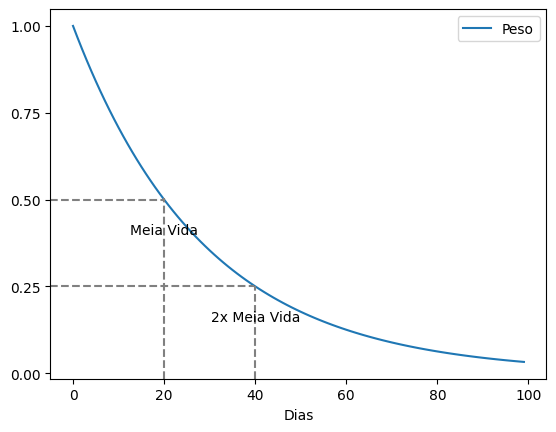

In [56]:
# Função de decaimento da meia-vida

half_life = 20
x = np.arange(0, 100)
y = np.power(0.5, x / half_life)
df2 = pd.DataFrame({'Dias': x, 'Peso': y})

ax = df2.plot(x='Dias', y='Peso')

ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.axvline(x=20, linestyle='--', color='gray', ymax=0.49)
ax.axvline(x=40, linestyle='--', color='gray', ymax=0.25)
ax.axhline(y=0.5, linestyle='--', color='gray', xmax=0.23)
ax.axhline(y=0.25, linestyle='--', color='gray', xmax=0.41)
ax.text(20, 0.4, 'Meia Vida', ha='center')
ax.text(40, 0.15, '2x Meia Vida', ha='center')

plt.show()

In [34]:
# Obtenha o timestamp de data/hora do evento mais recente no df
last_date = df.select(f.max('event_time')).collect()[0][0]
df = df.withColumn('last_date', f.lit(last_date))

# Calcule a atualidade de cada evento em termos de dias
df = df.withColumn('recency', (f.col('last_date').cast('double') - f.col('event_time').cast('double')) / 86400) # 86400 segundos = 24 horas
df = df.drop('last_date')

# Função de decaimento de meia-vida - o valor de um evento é reduzido pela metade após 20 dias
df = df.withColumn('recency_coef', f.expr('exp(ln(0.5)*recency/20)'))

In [35]:
# Número de visualizações, carrinhos e compras para cada par usuário-produto
interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1) * df['recency_coef']).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1) * df['recency_coef']).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1) * df['recency_coef']).alias('purchases'))
interactions = interactions.na.fill(0)

<font size=3>A matriz de interação é calculada atribuindo pesos a cada tipo de interação do usuário. Essas interações ponderadas são então somadas para obter a pontuação total da interação, que foi sujeita a uma função de decaimento de meia-vida para dar mais peso às interações recentes. Finalmente, os valores são transformados tomando o logaritmo com base 10 e limitando o valor máximo a 100 para garantir escalabilidade e consistência, ao mesmo tempo que elimina valores de outliers. A matriz resultante fornece uma medida da força do relacionamento entre usuários e produtos.

In [36]:
def calculate_interaction_matrix(df, view_weight=0.1, cart_weight=0.3, purchase_weight=1.0):

    # Crie uma nova coluna com o valor de interação ponderado
    df = df.withColumn('interaction', view_weight * col('views') + cart_weight * col('carts') + purchase_weight * col('purchases'))

    # Use o valor log10 para visualizações, carrinhos e compras
    df = df.withColumn('interaction', log10(col('interaction') + 1))

    # Defina o valor máximo possível para 100 (log100 = 2)
    df = df.withColumn('interaction', when(col('interaction') > 2, 2).otherwise(col('interaction')))

    return df

In [37]:
interaction_matrix = calculate_interaction_matrix(interactions)

In [38]:
#  Usuário-produto com as pontuações de interação mais altas

interaction_matrix.sort('interaction', ascending=False).show()

+---------+----------+------------------+------------------+------------------+------------------+
|  user_id|product_id|             views|             carts|         purchases|       interaction|
+---------+----------+------------------+------------------+------------------+------------------+
|543128872|   4804056|12.207319907787578| 6.350878846100495|13.566408609596607|1.2477868540168617|
|564068124|   1004767| 9.409194066085044| 8.493953105418917| 9.195022822534632|1.1362171329826278|
|518514099|   1005116|10.701412636919633| 4.396691063362743| 9.422111014877174| 1.107591831492107|
|513637414|   1004750|   8.0982070386193| 4.857399242716663| 8.912779204558994|1.0856408587382433|
|564068124|   1004833|12.571644064718809| 7.157168545931923| 6.874840533765673|1.0522765842505963|
|552639168|   4100346|16.347512089224168| 8.072243071616285|  6.20146270514749|1.0514568788115601|
|578710393|  16700764|2.8460524501896978| 5.744923890790875| 7.712717681446595|1.0302271979793014|
|521230795

<font size=3>Depois de criar uma matriz de interação que quantifica as interações usuário-produto usando pesos, podemos alimentar essa matriz no algoritmo ALS. Este algoritmo usa a matriz para aprender os fatores latentes dos usuários e dos produtos, que podem então ser usados ​​para fazer recomendações personalizadas aos usuários.
    
<font size=3>Para otimizar o desempenho do algoritmo ALS, podemos usar um pipeline de validação cruzada, que nos permite testar e ajustar diferentes conjuntos de parâmetros para encontrar a melhor configuração para nosso sistema de recomendação. Em última análise, o objetivo é criar um modelo que possa fazer recomendações de produtos precisas e relevantes aos usuários com base em suas interações anteriores com o sistema.

In [39]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline

def cross_validate_als(interaction_matrix):
    
    # Define o Modelo
    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction',
              nonnegative=True, coldStartStrategy='drop', implicitPrefs=True)
    print('Modelo ALS Definido')

    # Definir a grade de parâmetros para ajuste de hiperparâmetros
    param_grid = ParamGridBuilder() \
        .addGrid(als.rank, [10, 15]) \
        .addGrid(als.regParam, [0.01, 0.05]) \
        .addGrid(als.alpha, [1.0, 5.0]) \
        .build()
    print('Grid de parâmetros definido.')

    # Definir o avaliador para calcular as métricas de avaliação
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
    print('Evaluator definido.')
    # Definir o validador cruzado para realizar a validação cruzada de 5 vezes
    #cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, collectSubModels=False)

    tvs = TrainValidationSplit(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, trainRatio=0.8)
    print('Cross-validator definido.')

    # Defina o pipeline para ajustar o modelo e avaliá-lo
    pipeline = Pipeline(stages=[tvs])
    print('Pipeline definido.')

    # Ajuste o pipeline aos dados e avalie o modelo
    model = pipeline.fit(interaction_matrix)
    print('Model ajustado.')
    return model

In [41]:
model = cross_validate_als(interaction_matrix)

# Modelo com menor valor de RMSE
bestModel = model.stages[0].bestModel

# Predicoes
predictions = bestModel.transform(interaction_matrix)

# Calcular métricas RMSE e MAE (Métricas de avaliação)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
rmse = evaluator.setMetricName('rmse').evaluate(predictions)
mae = evaluator.setMetricName('mae').evaluate(predictions)
print(' rmse:' + str(rmse) + ' mae:' + str(mae))

# Printando os parâmetros do modelo com o menor valor de RMSE
regParam = bestModel._java_obj.parent().getRegParam()
rank = bestModel._java_obj.parent().getRank()
alpha = bestModel._java_obj.parent().getAlpha()
print('rank:' + str(rank) + ' regParam:' + str(regParam) + ' alpha:' + str(alpha))

Cross-validating the ALS model...
ALS model defined.
Parameter grid defined.
Evaluator defined.
Cross-validator defined.
Pipeline defined.


Model fitted.


 rmse:0.2055556603734609 mae:0.07851633134978397
rank:10 regParam:0.01 alpha:1.0


<font size=3>Depois de identificar o melhor conjunto de parâmetros, podemos construir um modelo ALS diretamente, em vez de executar a função de validação cruzada repetidamente. Essa abordagem economiza tempo e recursos, tornando mais eficiente a geração de recomendações de produtos.

In [43]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

def simple_als(interaction_matrix):

    # Divisão de dados em treino e teste
    (train, test) = interaction_matrix.randomSplit([0.8, 0.2])

    # Definir o modelo ALS com hiperparâmetros otimizados
    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction',
              alpha=1, regParam=0.005, rank=15, implicitPrefs=True,
              nonnegative=True, coldStartStrategy='drop')

    # Ajustar o modelo ALS aos dados de classificação
    model = als.fit(train)

    # Predições
    predictions = model.transform(test)

    # Calcula métricas de RMSE e MAE
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
    rmse = evaluator.evaluate(predictions)
    mae = evaluator.setMetricName('mae').evaluate(predictions)
    print('test rmse:' + str(rmse) + ' mae:' + str(mae))

    return model

In [44]:
als_model = simple_als(interaction_matrix)

test rmse:0.04803049956400948 mae:0.0340299447288154


## Recommend Products for Users

In [84]:
# 3 ids de usuários aleatórios
user_subset = [565606905, 570112140, 564068124]

# Recomendando top 10 produtos para cada usuário
recommendations = sc.createDataFrame([(user, 0) for user in user_subset], ['user_id', 'product_id'])
recommendations = als_model.recommendForUserSubset(recommendations, 10)

In [85]:
recommendations.show()

+---------+--------------------+
|  user_id|     recommendations|
+---------+--------------------+
|565606905|[{1004767, 0.9865...|
|570112140|[{1005239, 0.0095...|
|564068124|[{1004833, 1.0896...|
+---------+--------------------+



In [86]:
# Usuário com ID 564068124

recs_for_user_1 = sc.createDataFrame(recommendations.collect()[2][1])
#recs_for_user_1 = sc.createDataFrame(recommendations.collect()[0][1])

recs_for_user_1.show()

+----------+-------------------+
|product_id|             rating|
+----------+-------------------+
|   1004833| 1.0896239280700684|
|   1004767| 1.0175837278366089|
|   1004856|  1.009300947189331|
|   1002544| 1.0079739093780518|
|   1005115| 0.9795106649398804|
|   1005239|0.30297431349754333|
|   1004873|0.26436281204223633|
|   4804718|0.24167221784591675|
|   1004870| 0.2313843071460724|
|   1004836|0.17872895300388336|
+----------+-------------------+



In [75]:
# Produtos com maior número de interações para o usuário

interactions.filter(col('user_id') == 564068124).sort('purchases', ascending=False).show()

+---------+----------+-------------------+-------------------+-------------------+
|  user_id|product_id|              views|              carts|          purchases|
+---------+----------+-------------------+-------------------+-------------------+
|564068124|   1004767|  9.409194066085044|   8.49395310541892|  9.195022822534632|
|564068124|   1004833| 12.571644064718809|  7.157168545931923|  6.874840533765673|
|564068124|   1004856|  1.606901882144161| 0.5656631308614644| 0.9481385502372464|
|564068124|   1005115| 1.1468325283454863|0.37688799706301856| 0.7700504564889128|
|564068124|   1004873| 1.1258507956876596| 0.4554657108700836| 0.7509968187093987|
|564068124|   1201465|                0.0|                0.0|0.45516946862820207|
|564068124|   1307310|0.36202084534411477|0.36202258794364384|0.45514135207024364|
|564068124|   1004875|                0.0| 0.4527087487670014| 0.4436525958044613|
|564068124|   1004320|                0.0|                0.0|0.41780163587193986|
|564

<font size=3>Ao gerar recomendações, podemos melhorar as pontuações da filtragem colaborativa (CF) incorporando recursos adicionais que resultam em recomendações mais envolventes e personalizadas. Com esta função, combinamos as pontuações do CF com outras duas características: a taxa de conversão do produto e os hábitos de consumo do usuário.

<font size=3>O cálculo envolve uma média ponderada dos três recursos. Por padrão, a pontuação CF tem o maior peso, mas podemos ajustar os pesos conforme necessário. Antes do cálculo da média, todos os recursos são dimensionados entre 0 e 1 para garantir um intervalo consistente. Após o cálculo, os recursos são reduzidos aos seus valores originais.

<font size=3>Vamos nos aprofundar nos recursos específicos:

<font size=3>- Pontuação CF: representa a confiança no envolvimento do usuário, calculada pelo algoritmo ALS. Ele captura as preferências e padrões nas interações usuário-produto.

<font size=3>- Taxa de conversão: mede a taxa de compra por visualização dos produtos. Priorizamos produtos com maiores taxas de conversão, pois possuem maior probabilidade de serem adquiridos após serem descobertos. Isso ajuda a garantir que as recomendações sejam eficazes para impulsionar as vendas reais.

<font size=3>- Hábitos de consumo: avaliamos os hábitos de consumo dos usuários com base no preço relativo médio das compras. Isso ajuda a identificar se os usuários tendem a preferir produtos mais caros e luxuosos ou preferem opções mais acessíveis para evitar recomendar produtos que se desviem significativamente do orçamento do usuário. Além disso, introduzimos um coeficiente de reforço de gastos, que favorece ligeiramente produtos com preços acima das preferências do usuário, a fim de gerar mais receitas. No entanto, é necessária cautela na definição deste coeficiente para evitar um impacto negativo do envolvimento nas nossas recomendações.

<font size=3>Ao combinar esses recursos e ajustar os pesos, pretendemos gerar recomendações que sejam envolventes e alinhadas com as preferências e comportamentos dos usuários.

In [76]:
def calculate_recommendation_scores_for_user(user_id, recs, products, users, coef_als_score=0.8):
    # Juntar os dados de produtos nas recomendações
    recs = recs.join(products.select('product_id', 'purchase_per_view', 'relative_price'), on='product_id')
    
    # Obter a média relativa do preço do usuário
    user_avg_relative_price = users.filter(col('user_id') == user_id).select('avg_relative_price_purchased').collect()[0][0]

    # Normalizar a pontuação de classificação (rating) para o intervalo de 0 a 2
    recs = recs.withColumn('rating', col('rating') / 2)
    
    # Normalizar a taxa de compra por visualização (purchase_per_view) para o intervalo de 0 a 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)
    
    # Normalizar o valor do preço relativo para o intervalo de -5 a 5
    recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)
    
    # Normalizar o preço médio relativo dos usuários para o intervalo de -1 a 1
    user_avg_relative_price = (user_avg_relative_price + 1) / 2

    # Calcular as pontuações de recomendação considerando apenas a pontuação ALS e a taxa de compra por visualização
    recs = recs.withColumn('recommendation_score', (recs['rating'] * coef_als_score + recs['purchase_per_view'] * (1 - coef_als_score)) / (coef_als_score + (1 - coef_als_score)))
    
    # Reescalar a pontuação de classificação (rating) para o intervalo original de 0 a 2
    recs = recs.withColumn('rating', col('rating') * 2)
    
    # Reescalar a taxa de compra por visualização (purchase_per_view) para o intervalo original de 0 a 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)
    
    # Reescalar o valor do preço relativo para o intervalo original de -5 a 5
    recs = recs.withColumn('relative_price', col('relative_price') * 10 - 5)
    
    # Reescalar a média do preço relativo dos usuários para o intervalo original de -1 a 1
    user_avg_relative_price = user_avg_relative_price * 2 - 1
    
    return recs

In [87]:
recs_user = calculate_recommendation_scores_for_user(564068124, recs_for_user_1, products, users)

In [88]:
# Add all product features to the recommendations dataframe

recs_user = recs_user.join(products, on='product_id', how='left')

In [89]:
# Products with the highest recommendation scores

recs_user.sort('recommendation_score', ascending=False).show()

+----------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-----+-----+---------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+
|product_id|             rating|   purchase_per_view|      relative_price|recommendation_score|        category_id|       category_code|views|carts|purchases|             price|         first_date|          last_date|   purchase_per_view|      cart_per_view|  purchase_per_cart|      relative_price|
+----------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-----+-----+---------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+
|   1004833| 1.0896239280700684|0.056461680963311986| -0.1325554920984846|  0.5864140537968593|20530